# Advanced Data Analysis Project 
## Decipher *Pax3* regulation during the neural stem cells differentiation

### Introduction
Neural tubes defects (NTDs) like spina bifida can be caused by loss-of-function or hypomorphic mutations in the *Pax3* gene, but this phenotype can be rescued by a *Pax7* expression in mice ([Zhou et al., 2022](https://doi.org/10.3390/jdb10020019), [Cop et al., 2016](https://doi.org/10.1038/nrdp.2015.7)). Pax3 and Pax7 are transcription factors (TF) involved in the differentiation and the proliferation of Neural Stem Cells (NSCs).  However, is it unclear which genes or pathways are regulated by these TF. So, we decided to analyze transcriptomic data to define which genes are regulated by Pax3 and Pax7 in order to understand better the whole differentiation process. We also have a list of the risk factor genes of the human NTDs. We obtained the murine orthologs thanks to the [genenames website](https://www.genenames.org/tools/hcop/). 

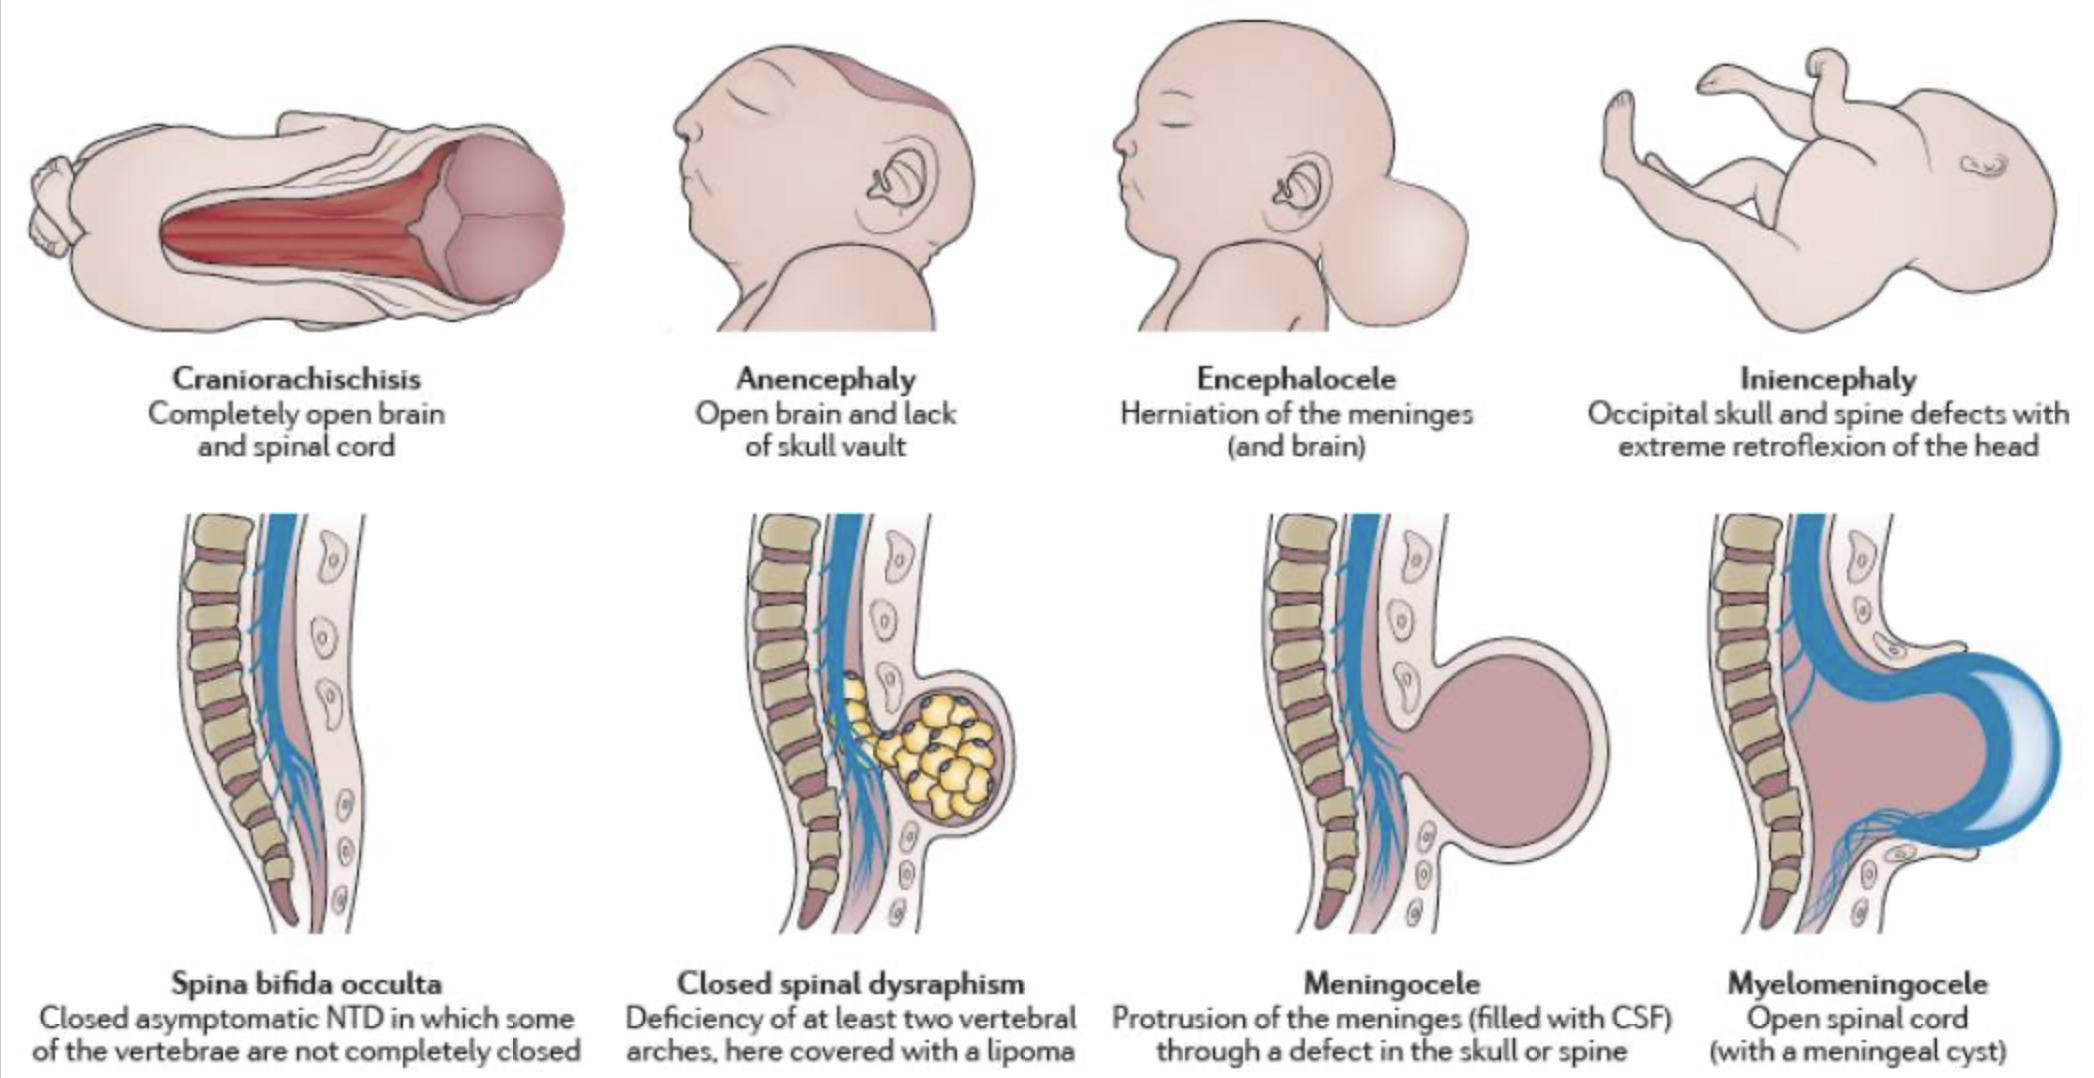

### Experiments
The first step made by the lab was to develop a model mimicking *in vitro* the NSC differentiation with Pax3/7 mutations. They performed knock-out of either Pax3, Pax7 or both in murine NSCs. Then, they isolated three clones for all the four condition: WT (HM1-rep1, HM1-rep2, HM1-rep3), *Pax3* KO (Px3m_A14, Px3m_A29, Px3m_A37), *Pax7* KO (Px7m_B16, Px7m_B29, Px7m_B34), *Pax3/7* KO (DKO_D1, DKO_D5, DKO_D27). The KO was possible with a 3kb deletion around the start codon of both genes. With the 12 resulting clones, they produced organoids for 5 days and introduced or not bone morphogenetic proteins (BMP) in the culture media between the 3rd and the 4th days to allow the differentiation. At the 5th day, they extracted the RNAs of around 50 organoids of each of the 24 samples. Then they proceeded to the transcriptome analysis with a bulk RNAseq platform. 
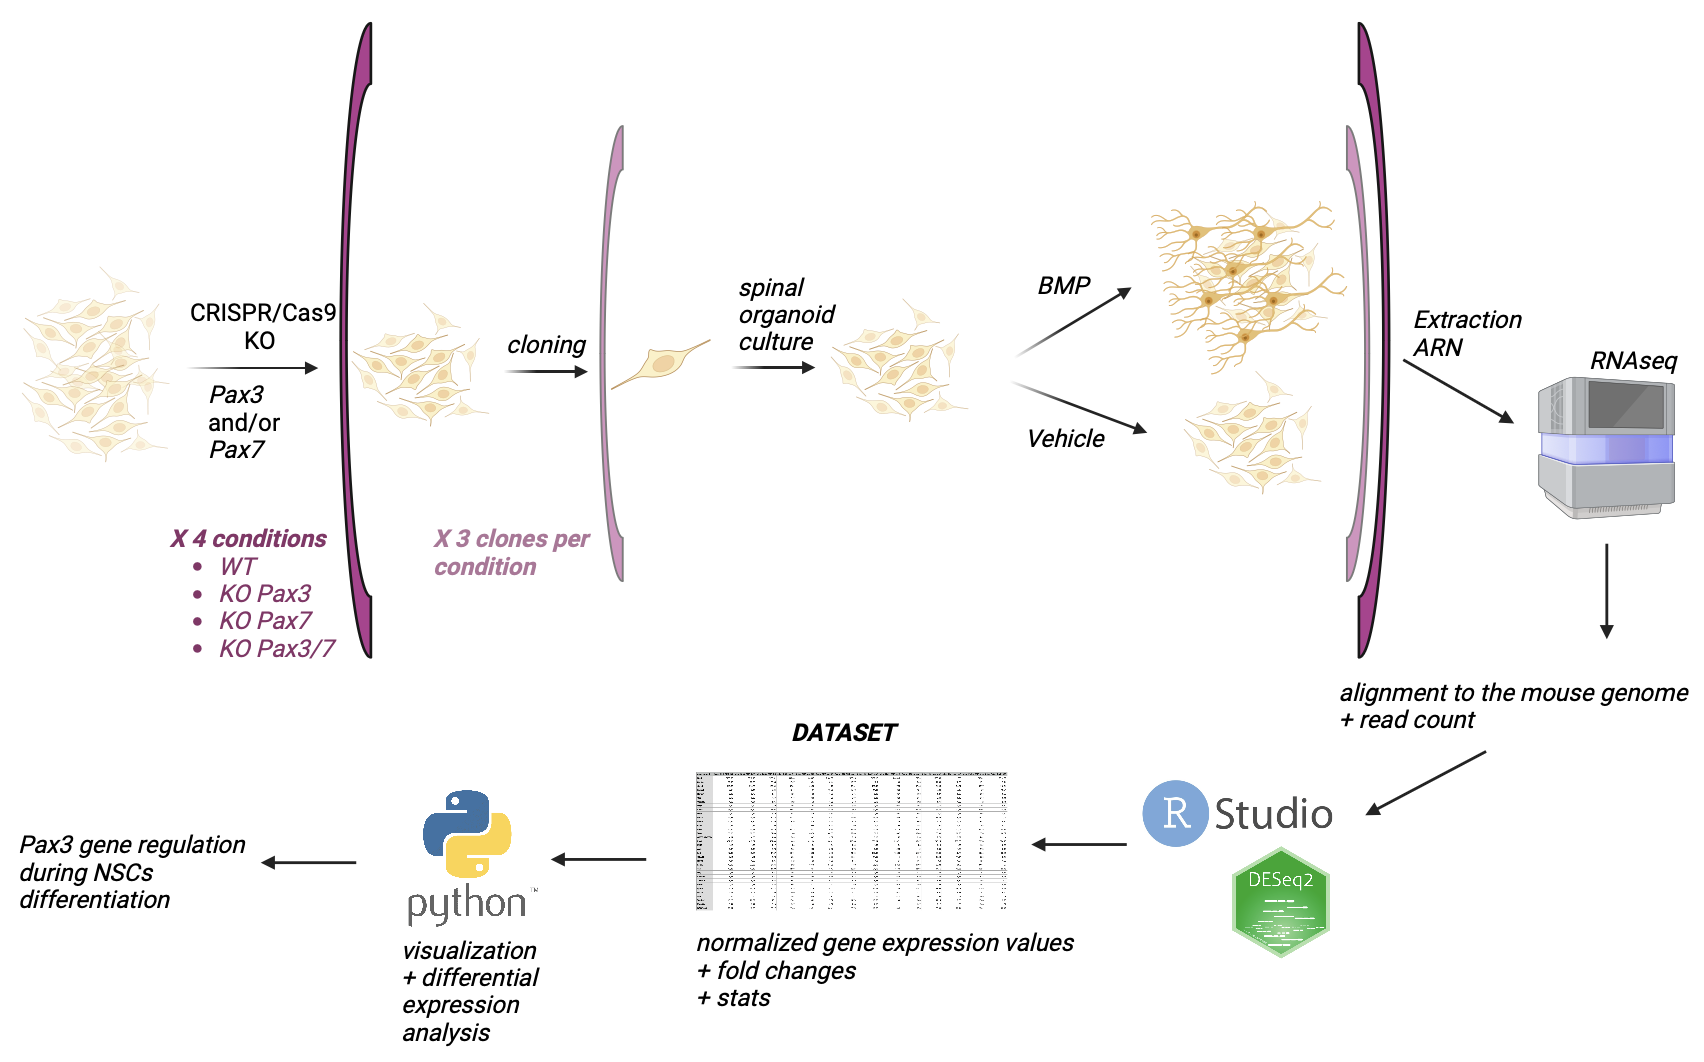

### Dataset description
Our initial dataset is made of 24 samples with an expression value for each of the 18031 murine genes. The expression unit is FPKM, for fragment per kilobase per million mapped fragments. The number of reads aligned to each genes were normalized to the size of the genes and the sequencing depth. It enables the expression comparison between the different genes thanks to the DESeq2 R package. They compared the FPKM values of the three replicates between two conditions and obtained a log2FC value, a p-value and a q-value for all the different possible comparisons. In summary, the dataset is a table of 75 columns and 18032 rows. The first row contains the name of the 24 samples but also the 17 differential expressions. The first column contains all the gene symbols. 

### Summary
In this analysis, our objective is to isolate the genes regulated by Pax3 and Pax7 during the NSCs differentiation.

1. Set the working directory and import functions and dataset 
2. Data structure
3. Data processing
    a) FPKM filtering
    b) Log transformation
    c) Triplicate average
4. Exploratory Data Analysis
    a) PCA plot
    b) Scree plot
5. Pre-clustering processing
    a) q-value filtering
    b) Density plot : number of genes *vs* fold change
6. Clustering 
    a) Hierarchical clustering : heatmap 
    b) K-mean : elbow plot
    c) K-mean : heatmap with 6 clusters
7. Gene extraction
    a) Structure of the risk factor list
    b) List of differentially expressed genes
    c) Volcano plot 
8. Conclusion

### 1. Set the working directory and import functions and dataset 

In [1]:
import os
os.chdir('/Users/lucasdenis/Desktop/Data_Analysis_project') #Replace your own path to the folder

from dataset import RNAseq_data, risk_factor_data, filter_fpkm, log_trans, mean_fpkm, filter_qvalue, gene_extraction
from visualization import scree_plot, plot_PCA, log2_plot, heatmap_hc, elbow_plot, heatmap_km, volcano_plot

import warnings #to make the notebook more readable
warnings.filterwarnings('ignore')

### 2. Data structure 
The dataset is composed of 18031 rows (genes) and 75 columns (fpkm values + fold changes + stats).

In [2]:
print(RNAseq_data.shape)
RNAseq_data.head()

(18031, 75)


,gene_symbol,fpkm_DKO_BMP_D1,fpkm_DKO_BMP_D27,fpkm_DKO_BMP_D5,fpkm_DKO_no_D1,fpkm_DKO_no_D27,fpkm_DKO_no_D5,fpkm_HM1_BMP_rep1,fpkm_HM1_BMP_rep2,fpkm_HM1_BMP_rep3,...,diffexp_deseq2_qvalue_Pax7mut_BMP-vs-DKO_BMP,diffexp_deseq2_pvalue_Pax7mut_BMP-vs-DKO_BMP,diffexp_log2fc_Pax7mut_no-vs-DKO_no,diffexp_deseq2_qvalue_Pax7mut_no-vs-DKO_no,diffexp_deseq2_pvalue_Pax7mut_no-vs-DKO_no,diffexp_log2fc_Pax7mut_no-vs-Pax7mut_BMP,diffexp_deseq2_qvalue_Pax7mut_no-vs-Pax7mut_BMP,diffexp_deseq2_pvalue_Pax7mut_no-vs-Pax7mut_BMP,diffexp_deseq2_qvalue_Pax7mut_no-vs-Pax7mut_BMP.1,diffexp_deseq2_pvalue_Pax7mut_no-vs-Pax7mut_BMP.1
0,Rps7,2193.38,2216.12,2168.51,2599.43,2358.70,2165.53,2420.28,2469.17,2403.48,...,0.049010,0.013580,0.196979,0.106592,0.027901,0.420192,0.041720,0.009322,0.041720,0.009322
1,Slc16a1,20.92,23.83,22.86,17.47,18.84,18.44,17.77,19.40,19.60,...,0.034081,0.008815,-0.168717,0.461028,0.217545,0.498297,0.046361,0.010595,0.046361,0.010595
2,Ccna2,119.82,114.73,120.84,102.51,99.52,111.76,106.61,105.45,117.62,...,0.976120,0.943054,0.029044,0.879370,0.693105,0.184815,0.095508,0.026352,0.095508,0.026352
3,Echdc2,9.07,9.44,9.84,10.46,10.10,10.86,10.79,11.31,10.83,...,0.001369,0.000213,0.208436,0.338964,0.137839,0.620232,0.002991,0.000407,0.002991,0.000407
4,Nanos1,0.99,0.75,1.11,1.23,1.03,1.59,0.75,0.96,0.81,...,0.834592,0.664128,0.428818,0.252660,0.090748,-0.151253,0.815252,0.576226,0.815252,0.576226


### 3. Data processing
#### a) FPKM filtering
FPKM is the normalized expression value of every gene in each condition. We want to focus on the genes with a minimum expression value, it's more meaningful from a biological and analytical point of view. So we chose a FPKM threshold of 1. If at least one of the gene fpkm value is below this threshold in one of the condition, we remove it. 

It results in keeping 10216 genes. 

In [3]:
RNAseq_filt_fpkm = filter_fpkm(RNAseq_data,fpkm_threshold=1)
print(RNAseq_filt_fpkm.shape)
RNAseq_filt_fpkm.head()

(10216, 75)


,gene_symbol,fpkm_DKO_BMP_D1,fpkm_DKO_BMP_D27,fpkm_DKO_BMP_D5,fpkm_DKO_no_D1,fpkm_DKO_no_D27,fpkm_DKO_no_D5,fpkm_HM1_BMP_rep1,fpkm_HM1_BMP_rep2,fpkm_HM1_BMP_rep3,...,diffexp_deseq2_qvalue_Pax7mut_BMP-vs-DKO_BMP,diffexp_deseq2_pvalue_Pax7mut_BMP-vs-DKO_BMP,diffexp_log2fc_Pax7mut_no-vs-DKO_no,diffexp_deseq2_qvalue_Pax7mut_no-vs-DKO_no,diffexp_deseq2_pvalue_Pax7mut_no-vs-DKO_no,diffexp_log2fc_Pax7mut_no-vs-Pax7mut_BMP,diffexp_deseq2_qvalue_Pax7mut_no-vs-Pax7mut_BMP,diffexp_deseq2_pvalue_Pax7mut_no-vs-Pax7mut_BMP,diffexp_deseq2_qvalue_Pax7mut_no-vs-Pax7mut_BMP.1,diffexp_deseq2_pvalue_Pax7mut_no-vs-Pax7mut_BMP.1
0,Rps7,2193.38,2216.12,2168.51,2599.43,2358.70,2165.53,2420.28,2469.17,2403.48,...,0.049010,0.013580,0.196979,0.106592,0.027901,0.420192,0.041720,0.009322,0.041720,0.009322
1,Slc16a1,20.92,23.83,22.86,17.47,18.84,18.44,17.77,19.40,19.60,...,0.034081,0.008815,-0.168717,0.461028,0.217545,0.498297,0.046361,0.010595,0.046361,0.010595
2,Ccna2,119.82,114.73,120.84,102.51,99.52,111.76,106.61,105.45,117.62,...,0.976120,0.943054,0.029044,0.879370,0.693105,0.184815,0.095508,0.026352,0.095508,0.026352
3,Echdc2,9.07,9.44,9.84,10.46,10.10,10.86,10.79,11.31,10.83,...,0.001369,0.000213,0.208436,0.338964,0.137839,0.620232,0.002991,0.000407,0.002991,0.000407
5,Gli2,6.18,6.39,7.47,7.76,6.63,7.56,9.87,8.83,8.88,...,0.001259,0.000193,-0.264694,0.095955,0.024204,0.084105,0.814761,0.575361,0.814761,0.575361


#### b) Log transformation
In order to stabilize the variance during the analysis and to get better visualizations, we do a log transformation on the filtered FPKM values. 

In [4]:
log_fpkm_data = log_trans(RNAseq_filt_fpkm)
log_fpkm_data.head()

,gene_symbol,fpkm_DKO_BMP_D1,fpkm_DKO_BMP_D27,fpkm_DKO_BMP_D5,fpkm_DKO_no_D1,fpkm_DKO_no_D27,fpkm_DKO_no_D5,fpkm_HM1_BMP_rep1,fpkm_HM1_BMP_rep2,fpkm_HM1_BMP_rep3,...,diffexp_deseq2_qvalue_Pax7mut_BMP-vs-DKO_BMP,diffexp_deseq2_pvalue_Pax7mut_BMP-vs-DKO_BMP,diffexp_log2fc_Pax7mut_no-vs-DKO_no,diffexp_deseq2_qvalue_Pax7mut_no-vs-DKO_no,diffexp_deseq2_pvalue_Pax7mut_no-vs-DKO_no,diffexp_log2fc_Pax7mut_no-vs-Pax7mut_BMP,diffexp_deseq2_qvalue_Pax7mut_no-vs-Pax7mut_BMP,diffexp_deseq2_pvalue_Pax7mut_no-vs-Pax7mut_BMP,diffexp_deseq2_qvalue_Pax7mut_no-vs-Pax7mut_BMP.1,diffexp_deseq2_pvalue_Pax7mut_no-vs-Pax7mut_BMP.1
0,Rps7,7.693655,7.703964,7.682257,7.863432,7.766290,7.680882,7.792052,7.812042,7.785089,...,0.049010,0.013580,0.196979,0.106592,0.027901,0.420192,0.041720,0.009322,0.041720,0.009322
1,Slc16a1,3.087399,3.212053,3.172203,2.916148,2.987700,2.967333,2.932260,3.015535,3.025291,...,0.034081,0.008815,-0.168717,0.461028,0.217545,0.498297,0.046361,0.010595,0.046361,0.010595
2,Ccna2,4.794302,4.751260,4.802709,4.639668,4.610357,4.725262,4.678514,4.667675,4.775925,...,0.976120,0.943054,0.029044,0.879370,0.693105,0.184815,0.095508,0.026352,0.095508,0.026352
3,Echdc2,2.309561,2.345645,2.383243,2.438863,2.406945,2.473171,2.467252,2.510412,2.470639,...,0.001369,0.000213,0.208436,0.338964,0.137839,0.620232,0.002991,0.000407,0.002991,0.000407
5,Gli2,1.971299,2.000128,2.136531,2.170196,2.032088,2.147100,2.386007,2.285439,2.290513,...,0.001259,0.000193,-0.264694,0.095955,0.024204,0.084105,0.814761,0.575361,0.814761,0.575361


#### c) Triplicate average
To prepare the following analysis, we average the three replicates for each condition.

In [5]:
RNAseq_mean_fpkm = mean_fpkm(log_fpkm_data)
print(RNAseq_mean_fpkm.shape)
RNAseq_mean_fpkm.head()

(10216, 83)


,gene_symbol,fpkm_DKO_BMP_D1,fpkm_DKO_BMP_D27,fpkm_DKO_BMP_D5,fpkm_DKO_no_D1,fpkm_DKO_no_D27,fpkm_DKO_no_D5,fpkm_HM1_BMP_rep1,fpkm_HM1_BMP_rep2,fpkm_HM1_BMP_rep3,...,diffexp_deseq2_qvalue_Pax7mut_no-vs-Pax7mut_BMP.1,diffexp_deseq2_pvalue_Pax7mut_no-vs-Pax7mut_BMP.1,DKO_BMP_mean,DKO_no_mean,HM1_BMP_mean,HM1_no_mean,Px3m_BMP_mean,Px3m_no_mean,Px7m_BMP_mean,Px7m_no_mean
0,Rps7,7.693655,7.703964,7.682257,7.863432,7.766290,7.680882,7.792052,7.812042,7.785089,...,0.041720,0.009322,7.693292,7.770201,7.796394,7.499098,7.843621,7.612171,7.848155,7.615035
1,Slc16a1,3.087399,3.212053,3.172203,2.916148,2.987700,2.967333,2.932260,3.015535,3.025291,...,0.046361,0.010595,3.157218,2.957060,2.991029,2.579319,2.892120,2.758472,3.326493,3.032702
2,Ccna2,4.794302,4.751260,4.802709,4.639668,4.610357,4.725262,4.678514,4.667675,4.775925,...,0.095508,0.026352,4.782757,4.658429,4.707371,4.459979,4.773564,4.565666,4.704879,4.619377
3,Echdc2,2.309561,2.345645,2.383243,2.438863,2.406945,2.473171,2.467252,2.510412,2.470639,...,0.002991,0.000407,2.346149,2.439660,2.482767,2.104521,2.428645,2.120295,2.640885,2.289904
5,Gli2,1.971299,2.000128,2.136531,2.170196,2.032088,2.147100,2.386007,2.285439,2.290513,...,0.814761,0.575361,2.035986,2.116461,2.320653,2.012165,2.147337,1.953187,2.274853,2.252511


### 4. Exploratory Data Analysis
#### a) PCA plot

We performe a Principal Component Analysis to have a better understanding of the organisation of the data between the different conditions and replicats.

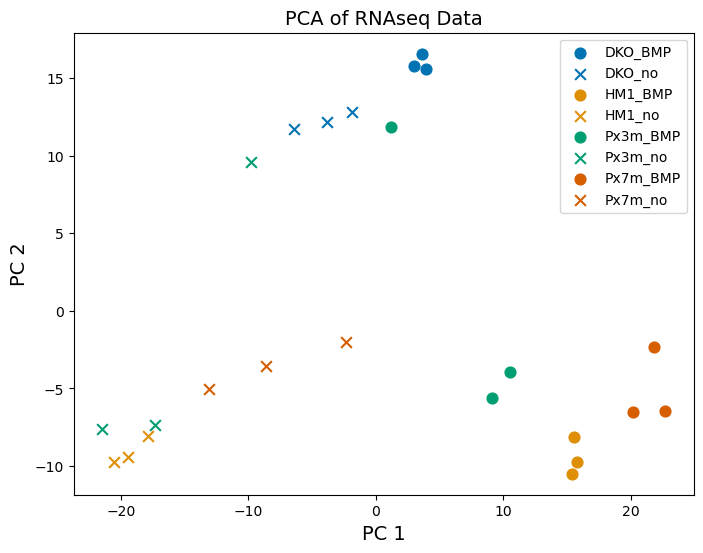

In [6]:
conditions = ['DKO_BMP','DKO_no','HM1_BMP','HM1_no','Px3m_BMP','Px3m_no','Px7m_BMP','Px7m_no']
plot_PCA(log_fpkm_data, conditions=conditions, columns='fpkm')

**Conlusion on the PCA**

We observe a very good separation of the clones treated with (dot) or without (cross) BMP by the PC1. We also observe with the PC2 a the separation of the double KO (Pax3 and Pax7) compared to single KO (Pax3 or Pax7) or WT (HM1).

However, we wee that one of the Pax3 KO replicat is separated from the others and cluster with the double KO. It could indicate a very intersting biological process or it could just be resulting of a mistake. In both case, we advice to verify the genomic and proteomic properties of the clone and to increase the number of replicates. We choose to keep this replicate in the analysis as a first approach but it would be interesting to analysis the impact of those replicats on the results.

#### b) Scree plot
In order to determine the variance explained by the different components oof the PCA, we designed a scree plot. It shows that PC1 and PC2 explain ~70% of the variance, which make our PCA efficient to separate conditions. Thanks to these two plots, we can confidently proceed to gene clustering methods.

<BarContainer object of 12 artists>

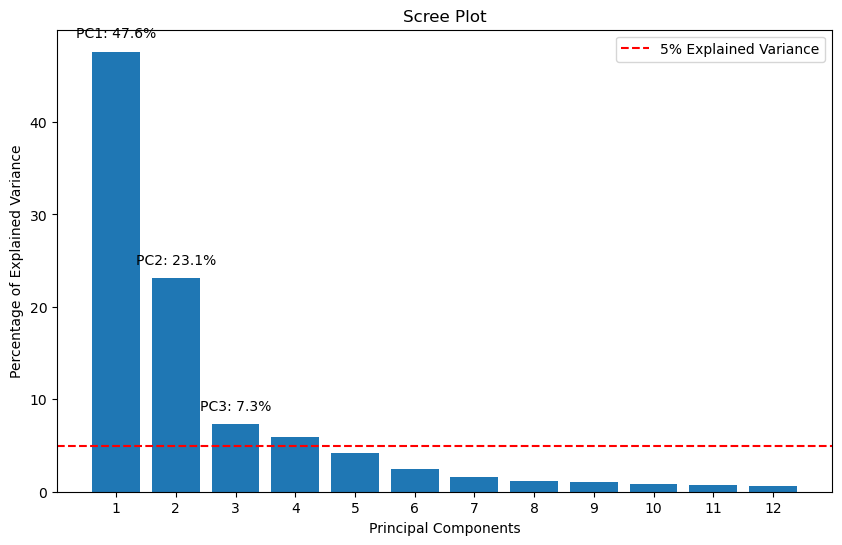

In [7]:
scree_plot(log_fpkm_data, columns='fpkm')

### 5. Pre-clustering processing
#### a) q-value filtering
From our data already filtered on the FPKM, we filter the genes on the q-value (corrected p-value for multiple comparisons). We keep the genes for which at least one of the q-value of the comparisons between conditions is lower than 0.05.

In [8]:
RNAseq_diff = filter_qvalue(RNAseq_mean_fpkm, 0.05)
print(RNAseq_diff.shape)
RNAseq_diff.head()

(9055, 83)


,gene_symbol,fpkm_DKO_BMP_D1,fpkm_DKO_BMP_D27,fpkm_DKO_BMP_D5,fpkm_DKO_no_D1,fpkm_DKO_no_D27,fpkm_DKO_no_D5,fpkm_HM1_BMP_rep1,fpkm_HM1_BMP_rep2,fpkm_HM1_BMP_rep3,...,diffexp_deseq2_qvalue_Pax7mut_no-vs-Pax7mut_BMP.1,diffexp_deseq2_pvalue_Pax7mut_no-vs-Pax7mut_BMP.1,DKO_BMP_mean,DKO_no_mean,HM1_BMP_mean,HM1_no_mean,Px3m_BMP_mean,Px3m_no_mean,Px7m_BMP_mean,Px7m_no_mean
0,Rps7,7.693655,7.703964,7.682257,7.863432,7.766290,7.680882,7.792052,7.812042,7.785089,...,0.041720,0.009322,7.693292,7.770201,7.796394,7.499098,7.843621,7.612171,7.848155,7.615035
1,Slc16a1,3.087399,3.212053,3.172203,2.916148,2.987700,2.967333,2.932260,3.015535,3.025291,...,0.046361,0.010595,3.157218,2.957060,2.991029,2.579319,2.892120,2.758472,3.326493,3.032702
2,Ccna2,4.794302,4.751260,4.802709,4.639668,4.610357,4.725262,4.678514,4.667675,4.775925,...,0.095508,0.026352,4.782757,4.658429,4.707371,4.459979,4.773564,4.565666,4.704879,4.619377
3,Echdc2,2.309561,2.345645,2.383243,2.438863,2.406945,2.473171,2.467252,2.510412,2.470639,...,0.002991,0.000407,2.346149,2.439660,2.482767,2.104521,2.428645,2.120295,2.640885,2.289904
5,Gli2,1.971299,2.000128,2.136531,2.170196,2.032088,2.147100,2.386007,2.285439,2.290513,...,0.814761,0.575361,2.035986,2.116461,2.320653,2.012165,2.147337,1.953187,2.274853,2.252511


#### b) Density plot : number of genes *vs*. fold change
The fold change is the ratio of the gene expression (FPKM) of two conditions. In the dataset we have 16 comparisons available, each composed of a log2(fold change) value and a q-value.

Plotting the number of genes in function of the fold change enables to visualize the proportion of the genes kept in the analysis if we decide to filter on a specific fold change. For example, with a fold change of 4, we keep a bit more than 200 genes. 

<AxesSubplot:title={'center':'Number of Genes vs. Fold Change Threshold'}, xlabel='Fold change', ylabel='Number of genes'>

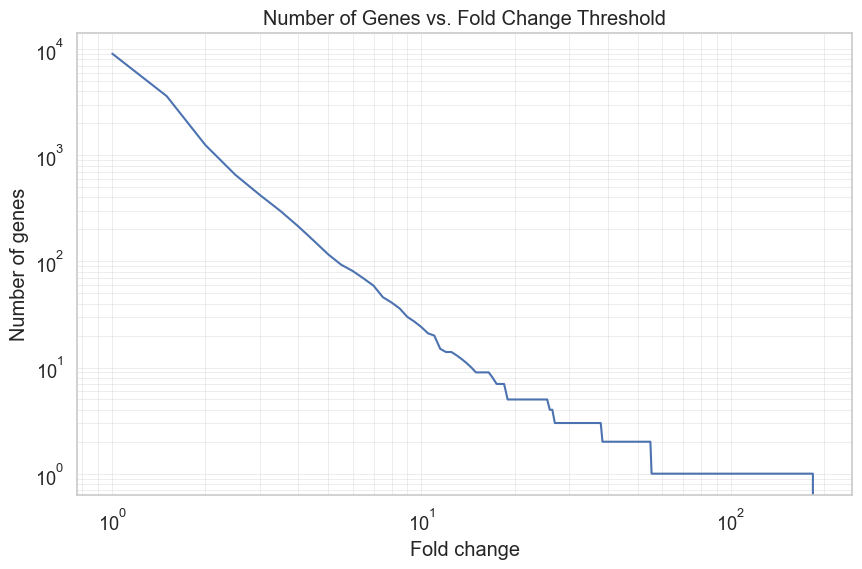

In [9]:
log2_plot(RNAseq_diff)

### 6. Clustering 
#### a) Hierarchical clustering : heatmap of the filtered gene expressions in all conditions
The following heatmap results from a hierarchical clustering of the average FPKM previously computed for the 8 conditions. We chose a fold change threshold of 4.

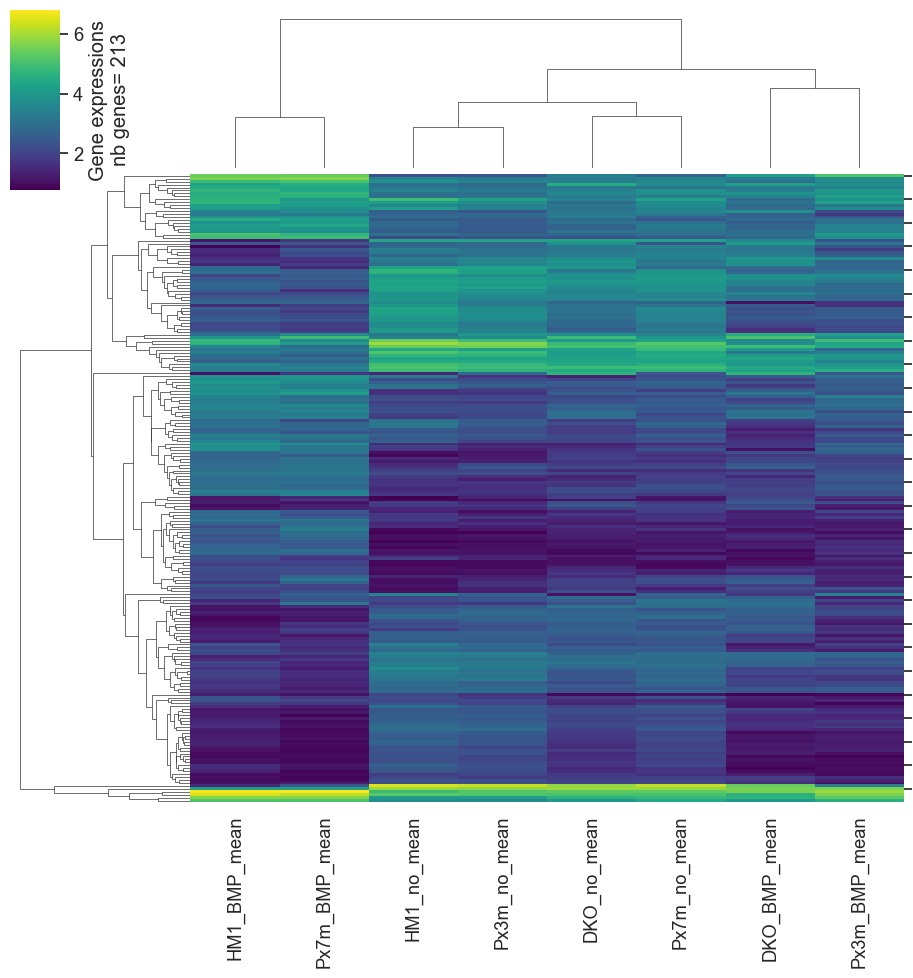

In [10]:
heatmap_hc(RNAseq_diff, columns='mean', fc_threshold=4)

**Conlusion on the hierachical clustering heatmap**

First, we see that the 4 no_BMP conditions cluster together in the midle of the heatmap, emphasizing the role of BMP on gene expression (transcription factor involved in differentiation).

Then we see that the mutated Pax7 and WT (HM1) with BMP cluster together, indicating that Pax7 seems to play a minor role on the gene expression level.

Finally, we see that the conditions furthest apart are mutated Pax3 and WT, indicating that Pax3 transcription factors seems to play an important role during differentiation.

#### b) K-mean : elbow plot
To choose the optimal number of cluster for the k-mean clustering. We calculate the inertia (representing the variance explained by the different number of clusters) for different values of k. We chose again a fold change threshold of 4. After this analysis choose k=6. 

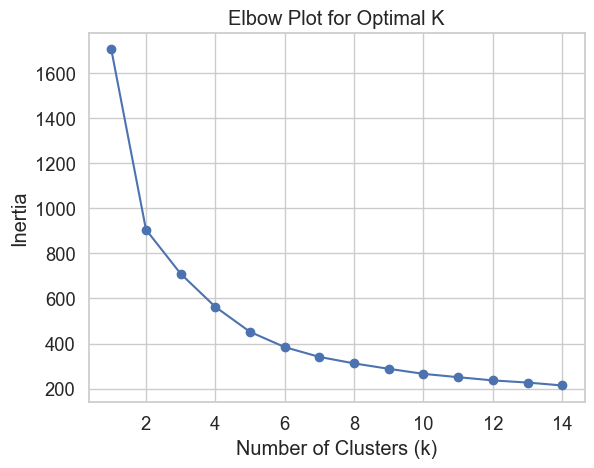

In [11]:
elbow_plot(RNAseq_diff, columns='mean', fc_threshold=4)

#### c) K-mean : heatmap with 6 clusters
For the fixed k and the threshold fold change, we ploted the genes on an heatmap to visualize the different gene clusters across the different conditions (here k=6).

<AxesSubplot:title={'center':'Gene Expression Heatmap - 6 clusters'}, xlabel='Conditions', ylabel='Genes (n=213)'>

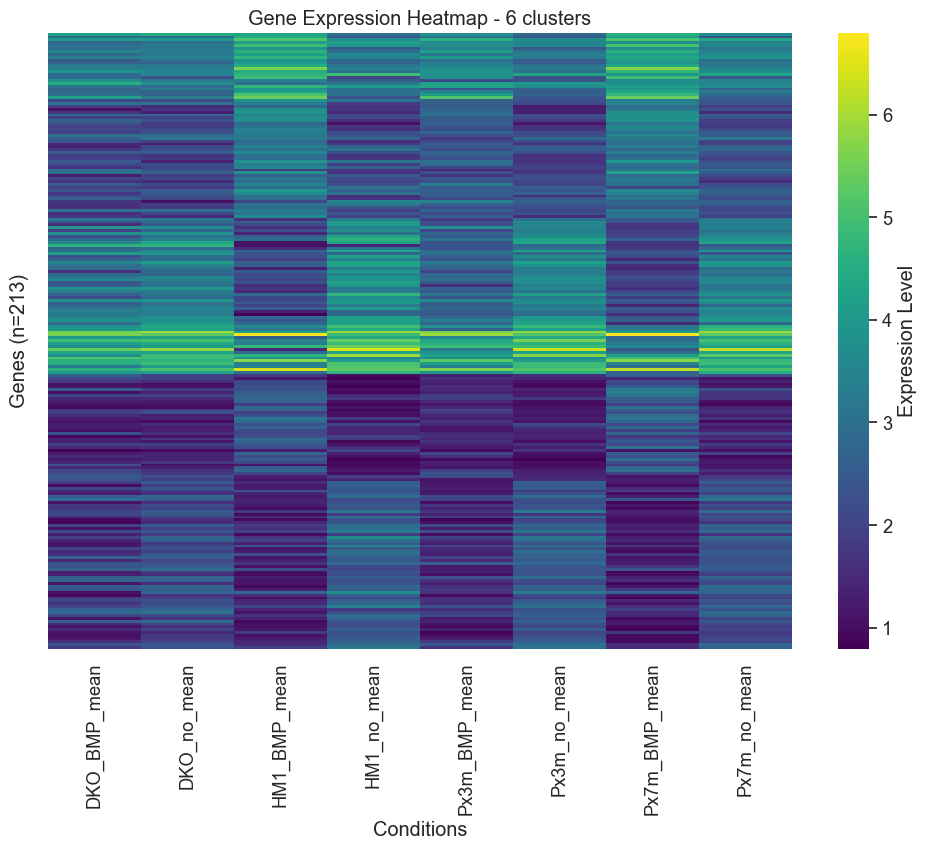

In [19]:
heatmap_km(RNAseq_diff, columns='mean', fc_threshold=4, k=6)

**Conlusion on the k-mean clustering heatmap**

The k-mean clustering heatmap shows the groups of genes that are differentially expressed between conditions.

First, we see that in the two DKO conditions, the presence of BMP doesn't impact much the gene level expression compare to the other pairs of conditions. Which is coherent with the results of our PCA.

We are also able to identified the groups of gene that are upregulated or downregulated when Pax3 is mutated (but BMP present) compared to the WT with BMP condition (HM1_BMP) which probably correspond to the genes regulated by Pax3 transcription factor in a physiological context.

### 7. Gene extraction
#### a) Volcano plot

To visualize the genes with a significant q-value (< 0.05) and fold change > 4 between two conditions of interest, we use a volcano plot.

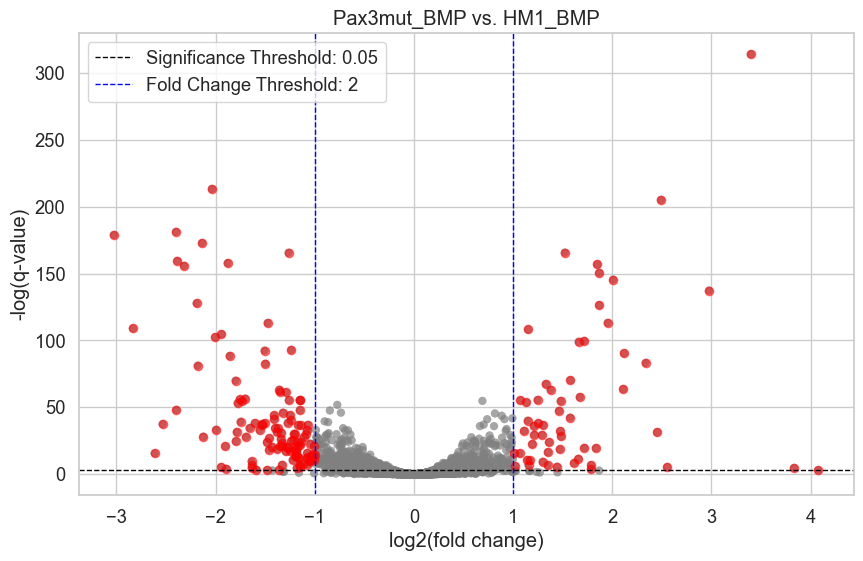

In [22]:
volcano_plot(RNAseq_filt_fpkm,condition_1='Pax3mut_BMP',condition_2='HM1_BMP',fc_threshold=2)

In [29]:
#we can extract the list of gene indicating in red
comparison_1 = gene_extraction(RNAseq_filt_fpkm, condition_1='Pax3mut_BMP', condition_2='HM1_BMP', fc_threshold=2)
print('The number of gene is: '+str(len(comparison_1)))
comparison_1

The number of gene is: 175


6        Osbpl10
79          Tox2
214         Bbc3
216      Fam181a
319       Scube2
          ...   
12092     Kctd12
12124    Ccdc189
12132       Dbx1
12142        Tes
12231      Rtl8c
Name: genes, Length: 175, dtype: object

#### b) Structure of the risk factor list
We then upload and visualize the dataset that encompasses genes identified as risk factors for Neural Tube Defects in human patients.

In [25]:
risk_factor_data.head()

(571, 11)


,Primary.species,Ortholog.species,Primary.symbol,Ortholog.symbol,Primary.species.DBID,Ortholog.species.DBID,Primary.Ensembl.ID,Ortholog.Ensembl.ID,Primary.NCBI.gene.ID,Ortholog.NCBI.gene.ID,Assertion.source.s.
0,Human,Mouse,COMT,Comt,HGNC:2228,MGI:88470,ENSG00000093010,ENSMUSG00000000326,1312,12846.0,"EggNOG,NCBI,Ensembl,Inparanoid,Panther,HomoloG..."
1,Human,Mouse,LMNB1,Lmnb1,HGNC:6637,MGI:96795,ENSG00000113368,ENSMUSG00000024590,4001,16906.0,"Inparanoid,NCBI,Ensembl,EggNOG,OrthoMCL,Phylom..."
2,Human,Mouse,LMNB1,Lmnb2,HGNC:6637,MGI:96796,ENSG00000113368,ENSMUSG00000062075,4001,16907.0,OrthoMCL
3,Human,Mouse,PRICKLE2,Prickle2,HGNC:20340,MGI:1925144,ENSG00000163637,ENSMUSG00000030020,166336,243548.0,"OrthoMCL,OrthoDB,EggNOG,NCBI,OMA,HGNC,Treefam,..."
4,Human,Mouse,PRICKLE2,Prickle1,HGNC:20340,MGI:1916034,ENSG00000163637,ENSMUSG00000036158,166336,106042.0,OrthoMCL


#### c) List of differentially expressed genes between WT and Pax3 KO clones
We now extract the list of the differentially expressed genes between two conditions of interest by filtering on the fold change and the q-value (correspond to the red doot on the previous volcano plot. 

We can then compare this list of genes with the identified risk factors genes from the risk_factor_dataset.

In [28]:
comparaison_1 = gene_extraction(RNAseq_filt_fpkm, condition_1='Pax3mut_BMP', condition_2='HM1_BMP', fc_threshold=2)
matches = comparaison_1.isin(risk_factor_data['Ortholog.symbol'])
print('The number of matches is: '+str(len(comparaison_1[matches]))+' genes')
comparaison_1[matches]

The number of matches is: 14 genes


499        Pax6
852        Pax3
1715       Rgma
1943     Plagl1
2953      Sall1
3493     Celsr1
3751        Nog
5749     Slc2a3
8705       Zic2
9534      Axin2
10294     Dact1
10656      Mfng
10879      Sox3
11891     Ephb3
Name: genes, dtype: object

This list of genes identified in our model has also been identified in human patients as risk factor genes of Neural Tube Defects (NTD).

### 8. Conclusion

This script allows us to visualize and have a better understanding of our RNAseq dataset. We can visualize the structure of the data and the differences between our conditions and their replicates. We were able to decipher a list of gene in our model that match with the identified risk factor genes in human patient with NTD.


**What's next**

It would be interesting from this list of genes to analyse the pathways in which they are involved during development and their specific role. It could allow us to identified specific pathways involved in NTD, or new therapeutic targets that could help to reduce the impact of these mutations during development.

Concerning the future possible improvements of this analysis, we could :
- Use more replicates in order to evaluate the real distribution
- Try to remove the outlier *Pax3* KO clone and run all the clustering steps again just with the diffentiated conditions. 
- Make a functional annotations of the genes in the same cluster of interest. It would be interesting to extract directly from the cluster the genes that are differentially expressed.